/var/folders/0w/44rywk3j1dl_gqy839v3wqyh0000gn/T/ipykernel_37320/1277941374.py:102: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(timesteps), freq='H')


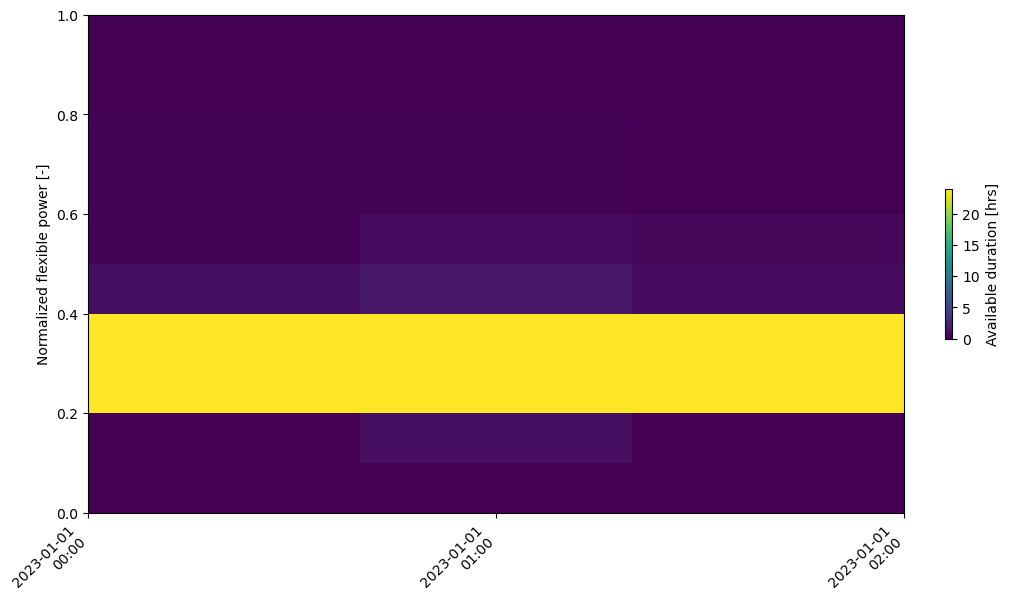

In [1]:
import numpy as np
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt


def get_duration_for_power_levels(upper_b_zones, lower_b_zones, power_levels, steps_per_hour, horizon_hrs):


    duration_vector = np.zeros(shape=power_levels.shape) #power levels are discretized into 53 levels

    # zone averaged power (if you have many zones) 
    if upper_b_zones.ndim > 1:
        upper_power = np.average(upper_b_zones, axis=1)
        lower_power = np.average(lower_b_zones, axis=1)
    else:
        upper_power = upper_b_zones
        lower_power = lower_b_zones

    upper_energy_bound = np.cumsum(upper_power) #from power to energy
    lower_energy_bound = np.cumsum(lower_power) #from power to energy

    for p in range(0, len(power_levels)): #for each power level
        query_power = np.ones(shape=upper_power.shape) * power_levels[p] #constant power trajectory
        query_energy_trajectory = np.cumsum(query_power) #from power to energy

        below_upper_bound = np.array([int(i <= j) for i, j in zip(query_energy_trajectory, upper_energy_bound)]) #1 if below upper bound, 0 if above
        above_lower_bound = np.array([int(i >= j) for i, j in zip(query_energy_trajectory, lower_energy_bound)]) #1 if above lower bound, 0 if below

        # cut infeasable regions : What does it mean?
        if below_upper_bound[0] > 0.5 and above_lower_bound[0] > 0.5:
            if 0 in below_upper_bound:
                idx_to_cut = np.where(below_upper_bound < 0.5)[0][0]
                below_upper_bound = below_upper_bound[:idx_to_cut]
            if 0 in above_lower_bound:
                idx_to_cut = np.where(above_lower_bound < 0.5)[0][0]
                above_lower_bound = above_lower_bound[:idx_to_cut]

            duration_vector[p] = np.round(np.minimum(np.sum(below_upper_bound),
                                                        np.sum(above_lower_bound)) / steps_per_hour, decimals=3)
        else:
            duration_vector[p] = 0

    return duration_vector.reshape(1, -1)

def create_flex_matrix(timesteps, steps_per_hour=4, horizon_hrs=24, power_levels=np.linspace(0, 1, num=10)):
    
    flex_matrix = None
    for t in timesteps:
        ## get upper and lower bands - Add your own function here
        upper_b_zones, lower_b_zones = get_upper_and_lower_bands(t, steps_per_hour, horizon_hrs)

        duration_vector = get_duration_for_power_levels(upper_b_zones, lower_b_zones, power_levels, steps_per_hour, horizon_hrs)
        if flex_matrix is not None:
            flex_matrix = np.concatenate((flex_matrix, duration_vector), axis=0) 
        else:
            flex_matrix = duration_vector

    return flex_matrix

def get_upper_and_lower_bands(t, steps_per_hour, horizon_hrs):
    # Placeholder function - replace with actual implementation
    upper_b_zones = np.random.rand(int(steps_per_hour*horizon_hrs)) * 1  # Example data
    lower_b_zones = np.random.rand(int(steps_per_hour*horizon_hrs)) * 0.3   # Example data
    return upper_b_zones, lower_b_zones


def plot_flex(flex_matrix):

    figure, axes = plt.subplots(nrows= 1, ncols=1, figsize=(10, 6), constrained_layout=True)
    ymin = float(flex_matrix.columns.values[0])
    ymax = float(flex_matrix.columns.values[-1])
    xmin, xmax = mdates.date2num([flex_matrix.index[0], flex_matrix.index[-1]])
    pos = axes.imshow(np.flip(np.transpose(np.array(flex_matrix)), axis=0), cmap='viridis', aspect='auto', extent=[xmin, xmax, ymin, ymax])
    figure.colorbar(pos, ax=axes, location='right', label='Available duration [hrs]', shrink=0.3)
    # fig.colorbar(pcm, ax=axs[1:, :], location='right')
    axes.set_ylabel('Normalized flexible power [-]')
    # axes.xaxis_date()
    # -------- CUSTOM TICKS BASED ON flex_matrix.index --------
    # Convert datetime index to matplotlib date numbers
    xtick_positions = mdates.date2num(flex_matrix.index.to_pydatetime())
    axes.set_xticks(xtick_positions)

    # Optional: format x-axis labels nicely
    axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))

    # Optional: rotate tick labels for readability
    plt.setp(axes.get_xticklabels(), rotation=45, ha='right')

## Test the functions
if __name__ == "__main__":
    # Example parameters
    max_heat_flow = 100  # Example max heat flow
    power_levels = np.linspace(0, 1, num=10)  # Example power levels
    steps_per_hour = 4  # Example steps per hour
    timesteps = [0, 1, 2]  # Example timesteps

    flex_matrix = create_flex_matrix(timesteps, steps_per_hour=4, horizon_hrs=24, power_levels=power_levels)

    # Convert to DataFrame for easier handling (optional)
    import pandas as pd
    time_index = pd.date_range(start='2023-01-01', periods=len(timesteps), freq='H')
    flex_df = pd.DataFrame(flex_matrix, index=time_index, columns=power_levels)

    # Plotting
    plot_flex(flex_df)

Julie method


In [ ]:
import numpy as np

def flexibility_envelope(upper_b, lower_b, steps_per_hour=4, horizon_hrs=24,
                         power_levels=np.linspace(-12, 14, 53)):
    """
    Compute the flexibility envelope (sustained duration in hours)
    for each power level and lead time.

    Parameters
    ----------
    upper_b : np.ndarray
        Upper power bound array of shape (96, 96) [episodes x horizon]
    lower_b : np.ndarray
        Lower power bound array of shape (96, 96)
    steps_per_hour : int
        Time discretization (e.g. 4 for 15 min)
    horizon_hrs : int
        Prediction horizon in hours (e.g. 24)
    power_levels : np.ndarray
        Discretized feasible power levels [kW]

    Returns
    -------
    durations : np.ndarray
        (53, 96) matrix — sustained duration [hours]
        rows = power levels, columns = lead times
    """
    n_lead_times = upper_b.shape[0]
    durations = np.zeros((len(power_levels), n_lead_times))

    # Loop over each lead time (row)
    for t in range(n_lead_times):
        upper_power = upper_b[t, :]
        lower_power = lower_b[t, :]

        # Convert from power [kW] to cumulative energy [kWh]
        upper_energy = np.cumsum(upper_power) / steps_per_hour
        lower_energy = np.cumsum(lower_power) / steps_per_hour

        # Evaluate each power level
        for i, p in enumerate(power_levels):
            query_energy = np.cumsum(np.ones_like(upper_power) * p) / steps_per_hour

            below_upper = query_energy <= upper_energy
            above_lower = query_energy >= lower_energy

            # Check if feasible at t=0
            if below_upper[0] and above_lower[0]:
                # truncate infeasible tails
                if not np.all(below_upper):
                    below_upper = below_upper[:np.argmax(~below_upper)]
                if not np.all(above_lower):
                    above_lower = above_lower[:np.argmax(~above_lower)]

                # duration in hours
                dur = min(len(below_upper), len(above_lower)) / steps_per_hour
            else:
                dur = 0

            durations[i, t] = np.round(dur, 3)

    return durations


In [ ]:
# Suppose you have daily building-level UB/LB
ub_day = bounds_dict["build1241_clim0_day9_UB"]
lb_day = bounds_dict["build1241_clim0_day9_LB"]

durations = flexibility_envelope(ub_day, lb_day, steps_per_hour=4, horizon_hrs=24)

print("Durations shape:", durations.shape)  # (53, 96)


In [ ]:
import matplotlib.pyplot as plt

def plot_envelope(durations, power_levels):
    plt.figure(figsize=(8,5))
    plt.imshow(durations, origin='lower', aspect='auto',
               extent=[0, 24, power_levels[0], power_levels[-1]],
               cmap='viridis')
    plt.colorbar(label="Sustained duration [hours]")
    plt.xlabel("Lead time [hours]")
    plt.ylabel("Power level [kW]")
    plt.title("Flexibility Envelope Surface")
    plt.tight_layout()
    plt.show()

plot_envelope(durations, np.linspace(-12,14,53))
